# FIX: Fixpoint-Quantisierung im Zeitbereich #
## Grundlagen: Quantisierung und Überlauf ##

In diesem Notebook wird gezeigt, wie verschiedene Arten der Quantisierung und des Überlauf-/Sättigungsverhaltens den Quantisierungsfehler beeinflussen und zwar anhand von 

- Quantisierungskennlinie
- Wellenform eines quantisierten Signals


In [1]:
import os, sys
import time

module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)

    import dsp_nmigen.pyfda_fix_lib as fx
%matplotlib inline    

import matplotlib.pyplot as plt

plt.style.use('script.mplstyle')
import numpy as np

figsize = {"figsize":(13,7)}

In diesem Kapitel nutzen wir die Fixpointbibliothek `dsp_lib_fix.py`. Sie benötigen zunächst ein Dictionary (hier: `q_dict`), in dem das Format `QI.QF` am Ausgang des Quantisierers und sein Quantisierungs- und Überlaufverhalten definiert sind. 

Danach wird mit `Q = fx.Fixed(q_dict)` eine Instanz der Fixpointklasse `Fixed()` mit den definierten Quantisierungsoptionen instantiiert. Als Parameter können angegeben werden:
- '**WI**' : Anzahl der Integerbits
- '**WF**' : Anzahl der Fractionalbits
- '**quant**' : Art der Requantisierung
- '**ovfl**' : Überlaufverhalten

Lassen Sie sich mit `?fx.Fixed()` die Optionen anzeigen.

Das folgende Beispiel zeigt das Prinzip:

In [2]:
q_dict = {'WI':0, 'WF': 3,                 # number of ingeger and fractional bits
          'quant':'floor', 'ovfl': 'wrap'} # quantization and overflow behaviour
Q = fx.Fixed(q_dict)                      # instance of fixpoint class Fixed()
for i in np.arange(12)/10:                 # i = 0, 0.1, 0.2, ...
    print("q<{0:>3.2f}> = {1:>5.3f}".format(i, Q.fixp(i))) # quantize i
# ?fx.Fixed # show docstring / options of class Fixed()

q<0.00> = 0.000
q<0.10> = 0.000
q<0.20> = 0.125
q<0.30> = 0.250
q<0.40> = 0.375
q<0.50> = 0.500
q<0.60> = 0.500
q<0.70> = 0.625
q<0.80> = 0.750
q<0.90> = 0.875
q<1.00> = -1.000
q<1.10> = -1.000


## Quantisierung Zeitsignal
Im folgenden wird ein sinusförmiges Signal $s(t)$ quantisiert, dargestellt werden das quantisierte Signal $s_Q(t)$ und die Differenz der beiden, der Quantisierungsfehler $\epsilon(t)$.

2200 Überläufe (Sinussignal)
Rechenzeit: 1.48 ms für 10000 Quantisierungen



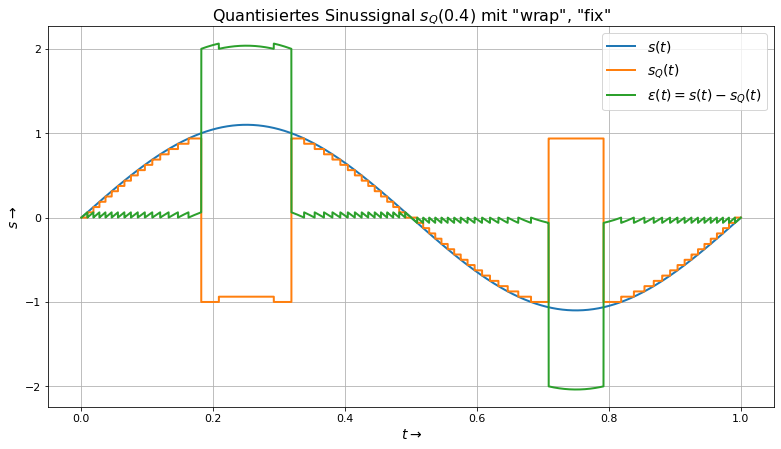

In [3]:
N = 10000; f_a = 1
t = np.linspace(0, 1, N, endpoint=False)
s = 1.1 * np.sin(2 * np.pi * f_a * t)
x = np.linspace(-2, 2, N, endpoint=False) 
#
q_dict = {'WI':0, 'WF': 4, 'quant':'fix', 'ovfl': 'wrap'} # try 'round' ; 'sat'
Q = fx.Fixed(q_dict) # quantizer instance with parameters defined above

t_cpu = time.perf_counter()

sq = Q.fixp(s) # quantize a
print('{0} Überläufe (Sinussignal)'.format(Q.N_over))
print('Rechenzeit: {0:.3g} ms für {1} Quantisierungen\n'.format((time.perf_counter()-t_cpu)*1000, Q.N))
#
fig1, ax1 = plt.subplots(**figsize)
ax1.set_title('Quantisiertes Sinussignal $s_Q$({0}.{1}) mit "{2}", "{3}"'.format(Q.WI, Q.WF, Q.ovfl, Q.quant))
ax1.plot(t, s, label = r'$s(t)$', lw=2)
ax1.step(t, sq, where = 'post', label = r'$s_Q(t)$', lw=2)
ax1.plot(t, s-sq, label = r'$\epsilon(t) = s(t) - s_Q(t)$', lw=2)
ax1.legend(fontsize = 14)
ax1.grid(True)
ax1.set_xlabel(r'$t \rightarrow$'); ax1.set_ylabel(r'$s \rightarrow$');
#

## Quantisierungskennlinie
Um das Quantisierungs- und Überlaufverhalten besser zu beobachten, tragen wir das quantisierte Signal $x_Q(t)$ gegenüber dem Eingangssignal $x(t)$ auf, $x(t)$ ist ein rampenförmiges Signal. Man könnte auch das sinusförmige Signal $s(t)$ aus dem vorigen Versuch verwenden, was wäre der Nachteil?

4844 Überläufe (Rampe)


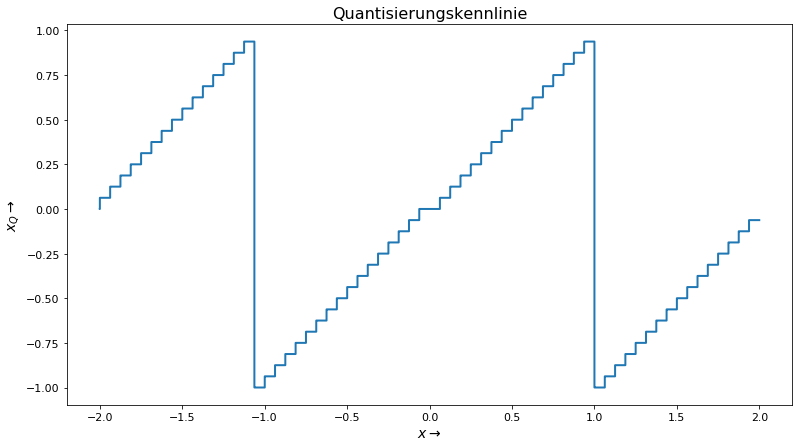

In [4]:
Q.resetN()    # Setze Überlaufzähler zurück
xq = Q.fixp(x) # quantize x
print('{0} Überläufe (Rampe)'.format(Q.N_over))
fig2, ax2 = plt.subplots(**figsize)
ax2.set_title('Quantisierungskennlinie')
ax2.step(x,xq, where = 'post')
#ax2.step(x,xq, s, sq, where = 'post')
ax2.set_xlabel(r'$x \rightarrow$'); ax2.set_ylabel(r'$x_Q \rightarrow$');

### Zahlenformate
Die quantisierten Werte lassen sich auch in anderen Zahlenformaten ausgeben, hier z.B. als Binary String:

In [5]:
q_dict_f = {'WI':0, 'WF': 8,               # number of ingeger and fractional bits
          'quant':'floor', 'ovfl': 'wrap', # quantization and overflow behaviour
          'frmt':'bin'}                    # output format
Q1 = fx.Fixed(q_dict_f)                    # instance of fixpoint class Fixed()
for i in np.arange(12)/10:                 # i = 0, 0.1, 0.2, ...
    print("q<{0:>3.2f}> = {1}".format(i, Q1.float2frmt(Q1.fixp(i)))) # quantize i + display it in the wanted format

q<0.00> = 0.00000000
q<0.10> = 0.00011001
q<0.20> = 0.00110011
q<0.30> = 0.01001100
q<0.40> = 0.01100110
q<0.50> = 0.10000000
q<0.60> = 0.10011001
q<0.70> = 0.10110011
q<0.80> = 0.11001100
q<0.90> = 0.11100110
q<1.00> = 1.00000000
q<1.10> = 1.00011001


### Zahlenformate
Die Zahlenformate lassen sich auch zurück in Floating Point Zahlen umwandeln:

In [6]:
q_dict_f = {'WI':0, 'WF': 4,               # number of int. and frac. bits
          'quant':'fix', 'ovfl': 'wrap', # quantization and overflow
          'frmt':'bin'}                    # output format
Q0 = fx.Fixed({'Q':'3.8', 'quant':'round', 'ovfl':'wrap', 'frmt':'bin'}) # no q. and ovfl
Q1 = fx.Fixed(q_dict_f)                    # instance of fixpoint class
frmt_str = "0.0x11"
x_org = Q0.frmt2float(frmt_str)
x_q = Q1.frmt2float(frmt_str)
print("q<b{0}> = {1} -> b{2} = {3}".format(frmt_str, x_org, 
                        Q1.float2frmt(x_q), x_q))

q<b0.0x11> = 0.375 -> b0.0110 = 0.375


Bug ?: Illegale Zeichen im frmt String führen bei frmt2float nicht zu Fehler, sondern werden ignoriert.

## Fragen und Experimente ##
- Finden Sie heraus, welche Optionen der Quantisierer unterstützt, indem Sie `?fx.Fixed` in einer Codezelle eingeben
- Testen Sie das Verhalten bei unterschiedlichen Quantisierungsarten und Überlaufoptionen

In [7]:
?fx.Fixed

***
### Copyright

(c) 2016 - 2019 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digitale Signalverarbeitung auf FPGAs"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources), feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2019*.